<a href="https://colab.research.google.com/github/bi-nguyen/Facebook_Student_Chatbot/blob/main/Bot_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchtext==0.6.0
!pip install vncorenlp
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/
!pip install scikit-learn

--2024-01-29 09:16:35--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   166MB/s    in 0.2s    

2024-01-29 09:16:36 (166 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2024-01-29 09:16:36--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
from torchtext.data import Field, TabularDataset, BucketIterator
import vncorenlp
from vncorenlp import VnCoreNLP
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from torchtext import data
import matplotlib.pyplot as plt
import pickle

In [ ]:
segment = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx2g')
def vi_token(text):
    text = segment.tokenize(text)
    text = [ele for inlist in text for ele in inlist]
    return text

In [ ]:
Vi = Field(tokenize=vi_token,
           eos_token="<eos>",
           init_token="<sos>",
           lower = True,
           batch_first=True
           )
Label = Field(sequential=False,use_vocab=False,batch_first=True)

In [ ]:
fields = {"Question":("question",Vi),"label":("label",Label)}

In [ ]:
train,test = TabularDataset.splits(
                                path = "/content/drive/MyDrive/chatbotschool/Data",
                                train = "data.csv",
                                test = "test_data.csv",
                                format = "csv",
                                fields = fields
)

In [ ]:
Vi.build_vocab(train)

In [ ]:
word_to_idx  = Vi.vocab.stoi
idx_to_word= Vi.vocab.itos

In [ ]:
vocablength = len(word_to_idx)

In [ ]:
vocablength

280

In [ ]:
len(idx_to_word)

280

In [ ]:
word_to_idx

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x789496c8ae00>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'em': 4,
             'ạ': 5,
             'hỏi': 6,
             'cho': 7,
             'có': 8,
             'ad': 9,
             'không': 10,
             'học': 11,
             'được': 12,
             'anh': 13,
             'mình': 14,
             'tiếng': 15,
             'ko': 16,
             'cơ_hội': 17,
             'về': 18,
             'học_phí': 19,
             'sao': 20,
             'rồi': 21,
             'thi': 22,
             'vào': 23,
             'ielts': 24,
             'thì': 25,
             'khoa': 26,
             'việc_làm': 27,
             'bao_nhiêu': 28,
             'dạ': 29,
             'du_học': 30,
             'toefl': 31,
             'cần': 32,
             'gì': 33,
             'vậy': 34,
             'đầu': 35,
          

# Model

In [ ]:
class Model(nn.Module):
    def __init__(self,input_dim,embedding_dim,hidden_dim,output_dim=13,p=0.5 ) -> None:
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.embedding = nn.Embedding(input_dim,embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim,hidden_size=hidden_dim,batch_first=True)
        self.linear = nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
        out = self.dropout(self.embedding(x))
        out,h = self.rnn(out)
        out = self.linear(h.squeeze(0))
        return out

# Hyperparameters

In [ ]:
learning_rate = 0.01
epoches = 600
batch_size = 16
embedding_dim = 32
hidden_dim = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_iterator,val_iterator = BucketIterator.splits(
                                (train,test),
                                batch_size = 16,
                                sort_key = lambda x: len(x.question),
                                sort_within_batch=True)

In [ ]:
data = iter(train_iterator)
question,label = next(data).question,next(data).label

In [ ]:
question.shape

torch.Size([16, 11])

In [ ]:
model= Model(input_dim=vocablength,embedding_dim=embedding_dim,hidden_dim=hidden_dim )

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model.parameters(),lr = learning_rate)

# Training

In [ ]:
def accuracy(actual,predict):
    return ((actual==predict).sum().item()/len(actual))*100

In [ ]:
def training(model:nn.Module,loss_fn:nn.Module,optim: torch.optim.Optimizer,data:torch.utils.data.DataLoader,device:torch.device):
    model.to(device)
    loss_train = 0
    acc_train = 0
    for (batch,sample) in enumerate(data):
        X = sample.question.to(device)
        y = sample.label.to(device)
        predict = model(X)
        predict_value = predict.argmax(1)
        acc_train+=accuracy(predict_value,y)
        loss = loss_fn(predict,y)
        loss_train+=loss.item()
        #
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss_train/len(data),acc_train/len(data)

In [ ]:
def test(model:nn.Module,loss_fn:nn.Module,optim: torch.optim.Optimizer,data:torch.utils.data.DataLoader,device:torch.device):
    model.to(device)
    loss_val = 0
    acc_val = 0
    model.eval()
    with torch.inference_mode():
        for (batch,sample) in enumerate(data):
            X = sample.question.to(device)
            y = sample.label.to(device)
            predict = model(X)
            predict_value = predict.argmax(1)
            acc_val=accuracy(predict_value,y)
            loss_val+=loss_fn(predict,y)
    return loss_val/len(data),acc_val/len(data)

In [ ]:
loss_train_accumulate, loss_val_accumulate = [],[]
acc_train_accumulate, acc_val_accumulate = [],[]
for epoch in range(epoches):
    loss_train ,acc_train = training(model,loss_fn,optim,train_iterator,device)
    loss_val,acc_val = training(model,loss_fn,optim,val_iterator,device)
    if (epoch+1)%20==0:
        print(f"epoches: {epoch+1:03d}| training_loss {round(loss_train, 4)}| Validation_loss {round(loss_val, 4)}|accuracy_train: {round(acc_train,4)}|accuracy_val: {round(acc_val,4)}")
        loss_train_accumulate.append(round(loss_train,4))
        loss_val_accumulate.append(round(loss_val,4))
        acc_train_accumulate.append(round(acc_train,4))
        acc_val_accumulate.append(round(acc_val,4))

epoches: 020| training_loss 2.0044| Validation_loss 2.003|accuracy_train: 34.6019|accuracy_val: 37.6961
epoches: 040| training_loss 1.3418| Validation_loss 1.3004|accuracy_train: 55.7084|accuracy_val: 56.7892
epoches: 060| training_loss 0.9932| Validation_loss 0.9864|accuracy_train: 68.1792|accuracy_val: 67.549
epoches: 080| training_loss 0.7786| Validation_loss 0.7607|accuracy_train: 76.3759|accuracy_val: 73.0637
epoches: 100| training_loss 0.5879| Validation_loss 0.6093|accuracy_train: 81.6306|accuracy_val: 80.7353
epoches: 120| training_loss 0.5133| Validation_loss 0.5235|accuracy_train: 83.8847|accuracy_val: 83.0637
epoches: 140| training_loss 0.4351| Validation_loss 0.5203|accuracy_train: 85.9631|accuracy_val: 83.7255
epoches: 160| training_loss 0.376| Validation_loss 0.4429|accuracy_train: 88.3197|accuracy_val: 86.299
epoches: 180| training_loss 0.3487| Validation_loss 0.4326|accuracy_train: 89.0369|accuracy_val: 87.7696
epoches: 200| training_loss 0.3079| Validation_loss 0.3195|

# Plotting

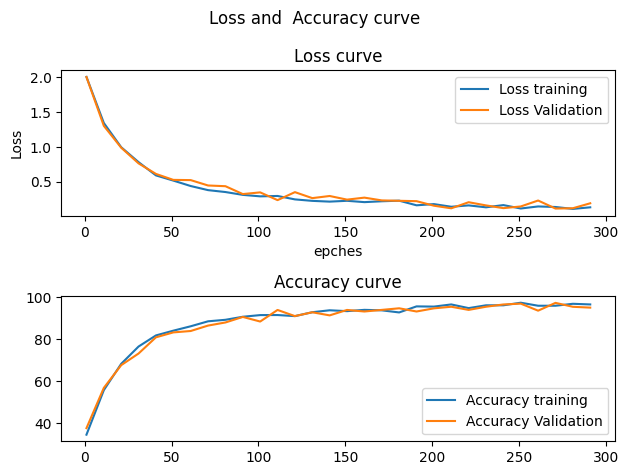

In [ ]:
fig, axs = plt.subplots(2)
fig.suptitle('Loss and  Accuracy curve')
axs[0].plot(range(1,301,10), loss_train_accumulate)
axs[0].plot(range(1,301,10),loss_val_accumulate)
axs[0].set_title('Loss curve')
axs[0].set(xlabel='epches', ylabel='Loss')
axs[0].legend(['Loss training', 'Loss Validation'])
axs[1].plot(range(1,301,10), acc_train_accumulate)
axs[1].plot(range(1,301,10),acc_val_accumulate)
axs[1].set_title('Accuracy curve')
axs[1].legend(['Accuracy training', 'Accuracy Validation'])
fig.tight_layout()

# Saving weight & vocab

In [ ]:
checkpoint = {
    "state_dict":model.state_dict(),
    "word_to_idx": word_to_idx.copy(),
    "idx_to_word" : Vi.vocab.itos.copy()
}

In [ ]:
torch.save(checkpoint,"/content/drive/MyDrive/chatbotschool/Weights/checkpoint3.pt")